In [1]:
from operator import attrgetter

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from notify_run import Notify
import igraph
from collections import Counter
from matplotlib.colors import LogNorm
sns.reset_defaults()
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

In [2]:
notify = Notify()
# notify.register()
renames = {'linear_ranking':'LR', 
           'mulambda':r'$(\mu,\lambda)$', 
           'original':'seminal', 
           'roulette_wheel': 'RWS',
           'single_elitist_rws':'E-RWS', 
           'tour_elite': 'E-TOS', 
           'tour_no_replace':'TOS -R',
           'tournament':'TOS +R'}


In [3]:
#verry important
os.chdir(r"C:/Users/nieli/Documents/uva/thesis/code/")
print(os.getcwd())

C:\Users\nieli\Documents\uva\thesis\code


### This is for n-d functions with optimum 0, new

In [4]:
df = pd.DataFrame(columns=['run_n', 'benchmark','selection_method','best_final_objval','best_objval','theoretical_optimum','dimensions'])

directory = 'PPA/results/results-2021-05-19_13-52-40/'
i = 0
for filename in os.listdir(directory):
    i+=1
    if i%500 == 0:
        print(f'total of {i/500*500} files read')
    file = pickle.load(open(directory+filename,"rb"))

    
    df = df.append({
        'run_n':file.run_n,
        'benchmark':file.benchmark_name, 
        'selection_method':file.survivor_selection_name,
        'best_final_objval': min(individual.objective_value for individual in file.parent_population), #this is the best object value at the end of the run
        'best_objval': file.best_objval_during_run.objective_value,   #this is the best obj value recorded during the run
        'theoretical_optimum': file.benchmark_optimum,
        'dimensions': file.benchmark_dimensions,
        'diplay_name': f"{file.benchmark_name}-{file.benchmark_dimensions:03d}D"
    }, ignore_index=True)
df.loc[df['selection_method'] == 'single_elitist_tournament','selection_method'] = 'tour_elite'
df.loc[df['selection_method'] == 'no_replacement_tournament','selection_method'] = 'tour_no_replace'
df.loc[df['selection_method'] == 'mupluslambda','selection_method'] = 'original'
df['error'] = abs(df['best_objval'] - df['theoretical_optimum'])
# df['benchmark'] = df.benchmark.str.replace("20", "d").str.replace("100", "f").str.replace("2", "a").str.replace("50", "e").str.replace("5", "b").str.replace("10", "c")

df = df.sort_values(by="benchmark")
df = df.astype({'theoretical_optimum':float,'error':float})
notify.send('Done reading all files')

total of 500.0 files read
total of 1000.0 files read
total of 1500.0 files read
total of 2000.0 files read
total of 2500.0 files read
total of 3000.0 files read
total of 3500.0 files read
total of 4000.0 files read
total of 4500.0 files read


In [14]:
df = df.replace({"selection_method": renames})
df_2d = df[~df['benchmark'].isin(['Ackley', 'Rosenbrock', 'Griewank', 'Rastrigrin', 'Schwefel', 'Ellipse', 'Cigar', 'Tablet',
                    'Sphere'])]
df_nd = df[df['benchmark'].isin(['Ackley', 'Rosenbrock', 'Griewank', 'Rastrigrin', 'Schwefel', 'Ellipse', 'Cigar', 'Tablet',
                    'Sphere'])]
df_2d = df_2d.sort_values(by=['benchmark','dimensions']).reset_index()
df_nd = df_nd.sort_values(by=['benchmark','dimensions']).reset_index()

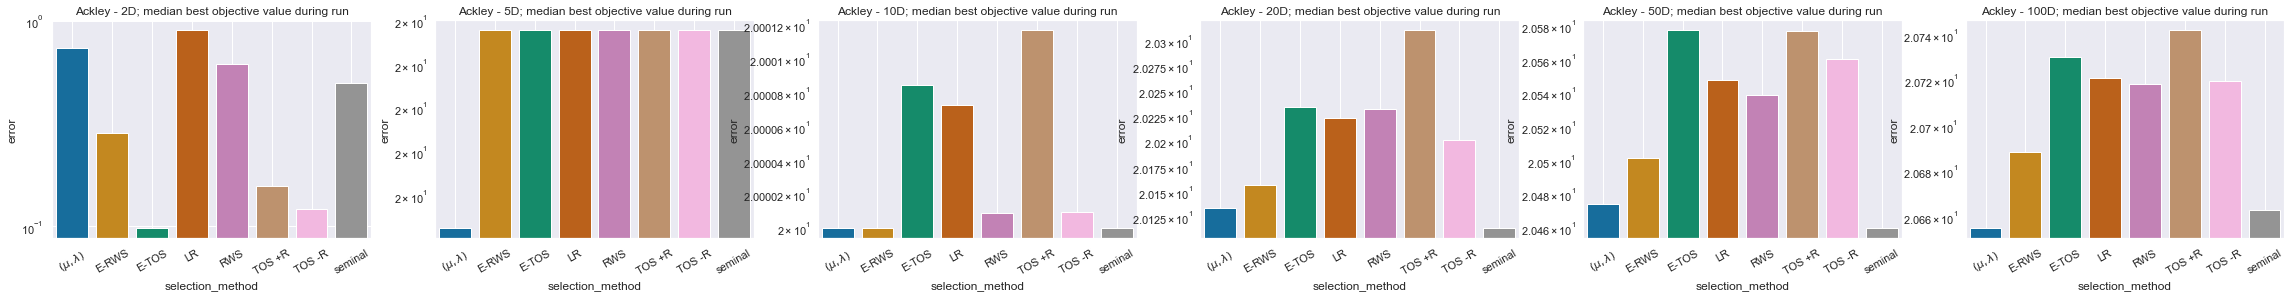

<Figure size 432x288 with 0 Axes>

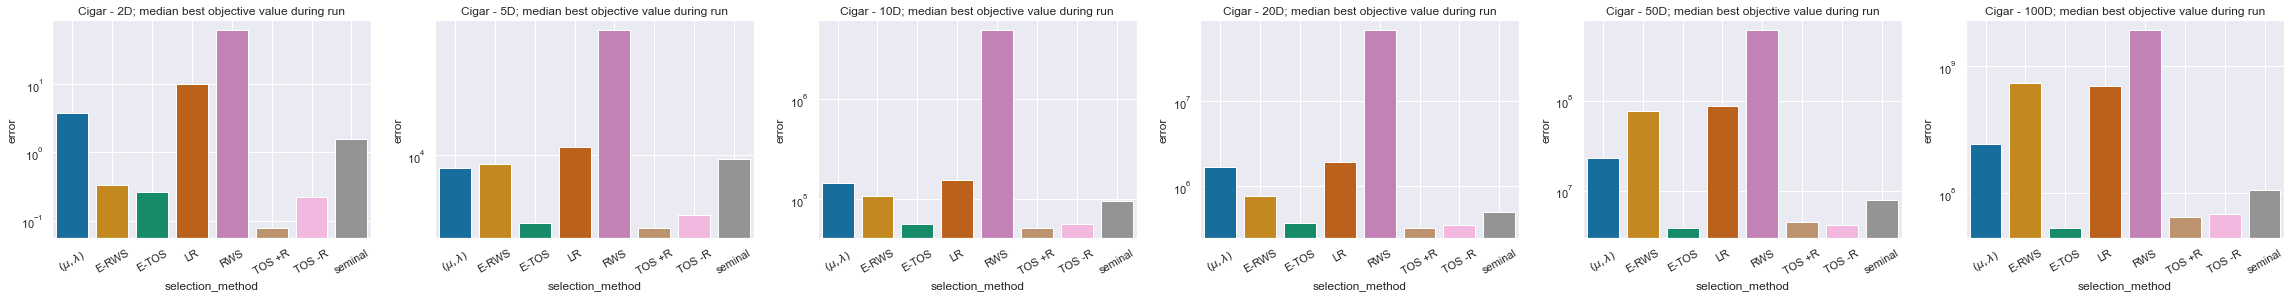

<Figure size 432x288 with 0 Axes>

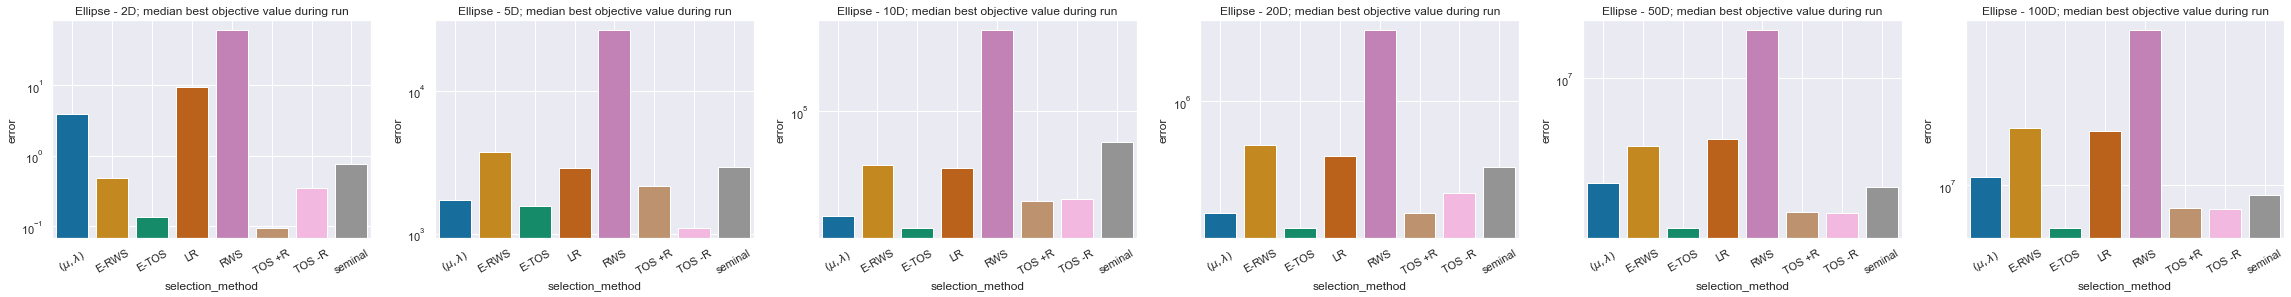

<Figure size 432x288 with 0 Axes>

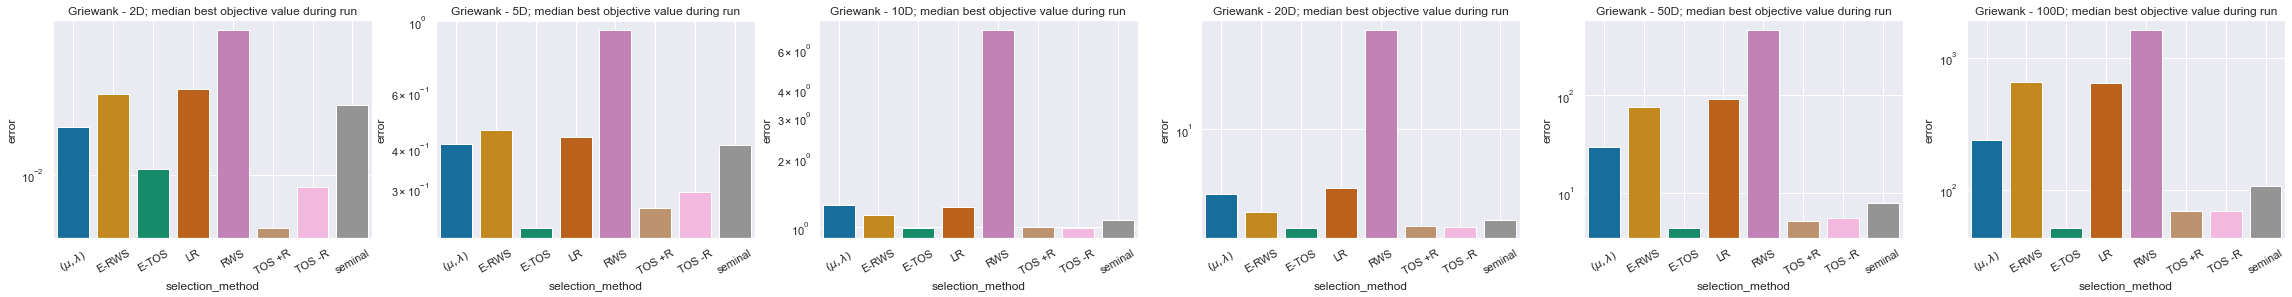

<Figure size 432x288 with 0 Axes>

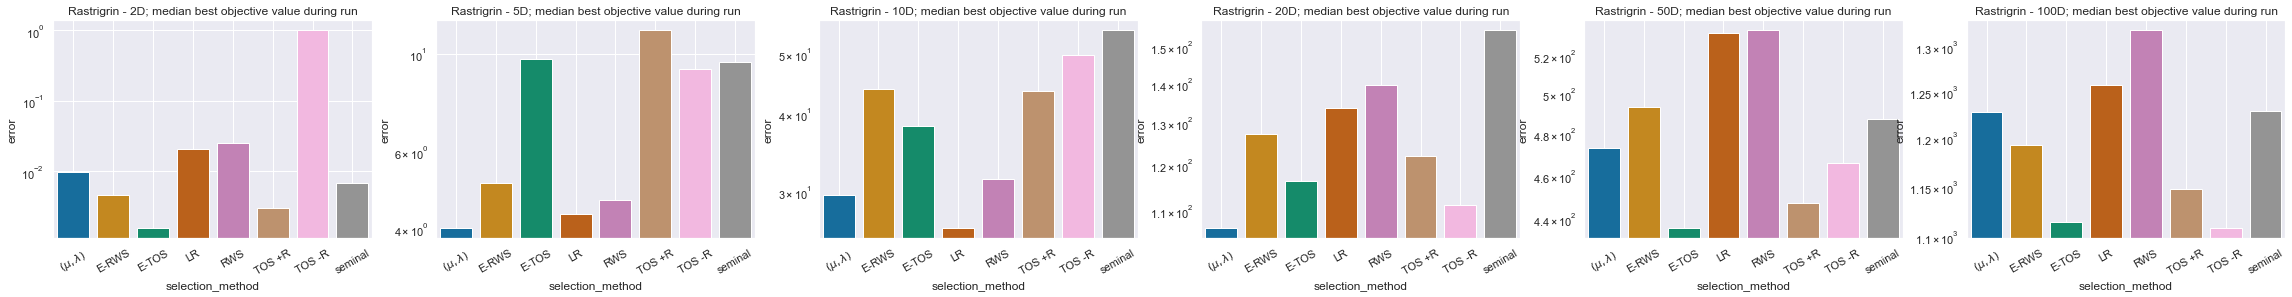

<Figure size 432x288 with 0 Axes>

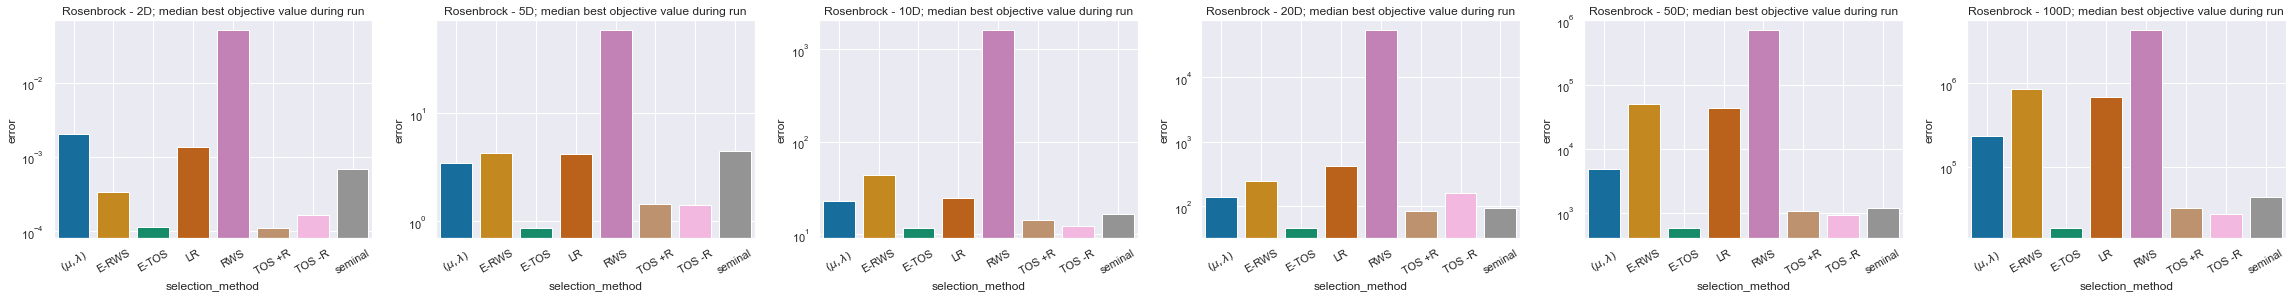

<Figure size 432x288 with 0 Axes>

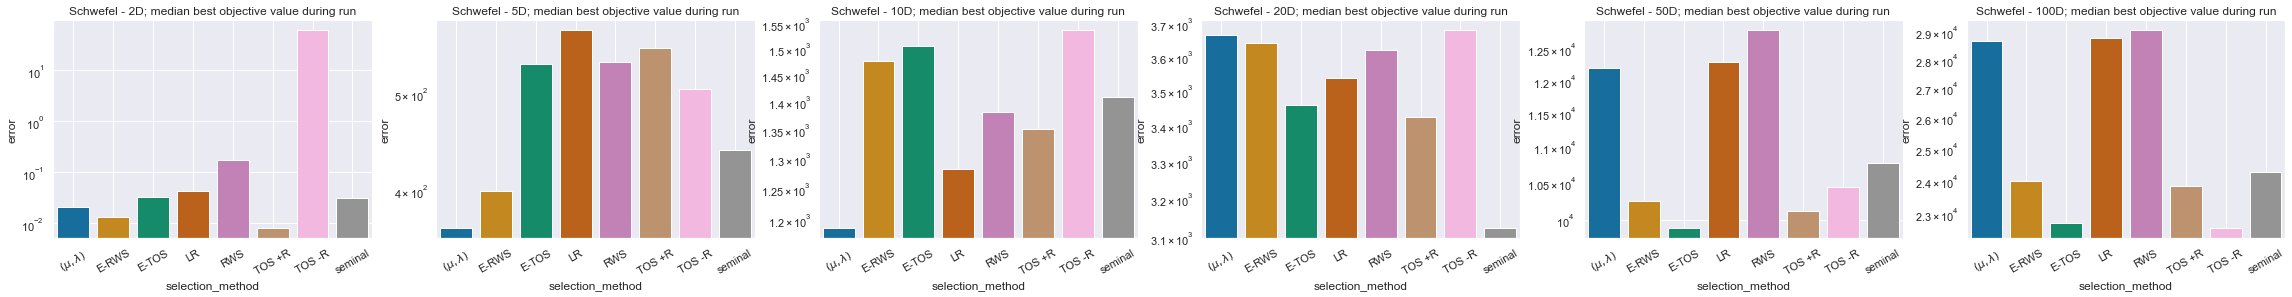

<Figure size 432x288 with 0 Axes>

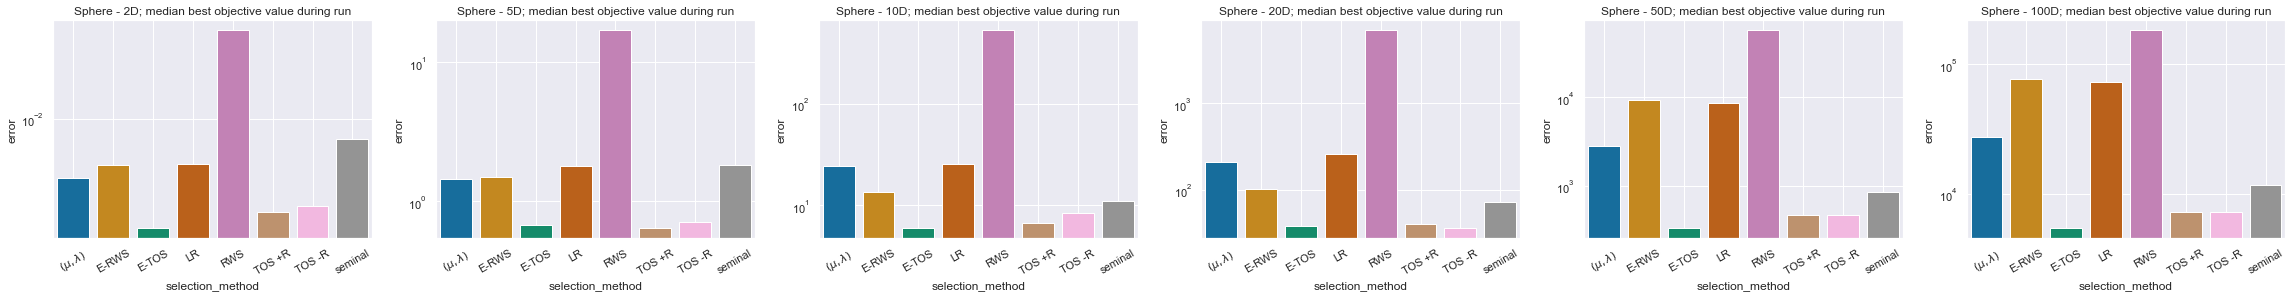

<Figure size 432x288 with 0 Axes>

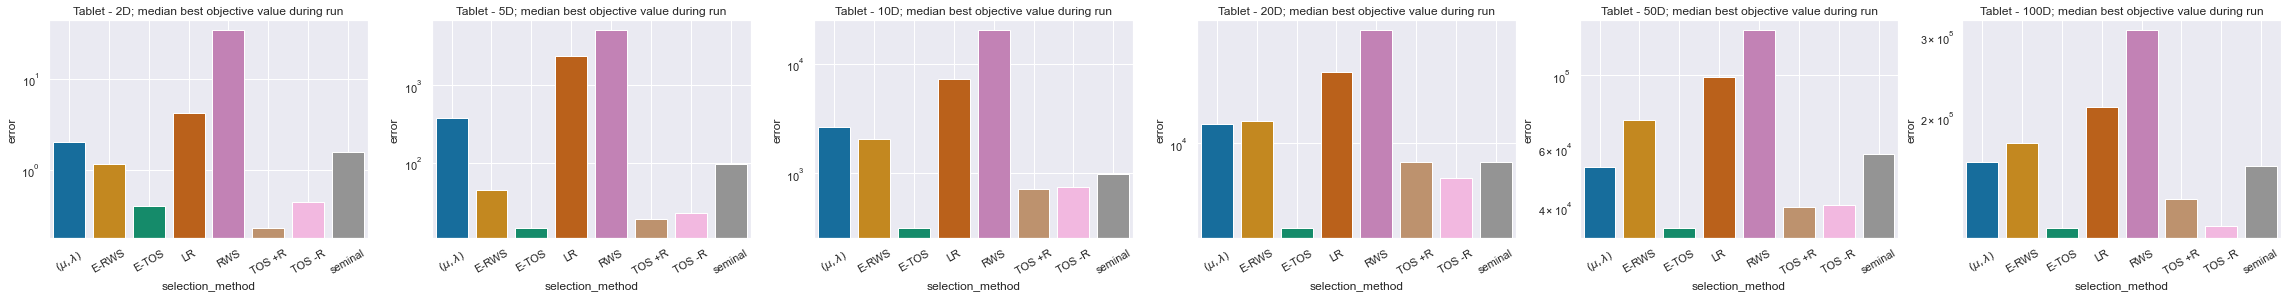

<Figure size 432x288 with 0 Axes>

In [15]:
benchmarks = df_nd.benchmark.unique()
i = 0
for benchmark in benchmarks:
    data = df_nd[df_nd['benchmark'] == benchmark]
    dimensions = data.dimensions.unique()
    fig, axes =plt.subplots(1,len(dimensions), figsize=(40,4))
    plot_data = data.groupby(['selection_method', 'dimensions']).median().reset_index()[['selection_method','error','dimensions']]
    i = 0
    for dim in dimensions:
        
        ax = sns.barplot(x="selection_method", y="error", data=plot_data[plot_data.dimensions == dim], ax=axes[i])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        ax.set_title(f'{benchmark} - {dim}D; median best objective value during run')

        ax.set_yscale("log")
        ax.grid()
        ax.yaxis.grid(True)
        
        i+=1
    plt.show()
    plt.savefig(f'PPA/notebooks/images/barcharts_per_benchmark/{benchmark}.png',bbox_inches='tight')
        
    

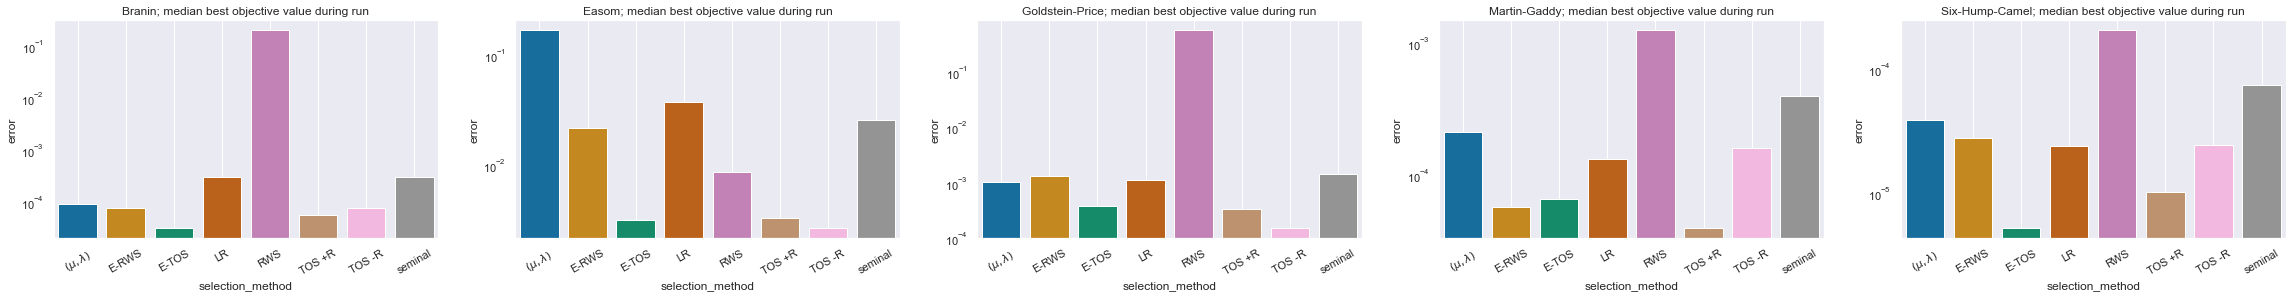

In [16]:
%matplotlib inline

fig, axes =plt.subplots(1,5, figsize=(40,4))
# fig.subplots_adjust(hspace=0.6)

benchmarks = df_2d.benchmark.unique()

i = 0
sns.set_palette("colorblind")
for benchmark in benchmarks:
    
    plot_data = df_2d[df_2d['benchmark'] == benchmark]
    optimum = plot_data['theoretical_optimum'][:1].item()
    plot_data = plot_data.groupby('selection_method').std().reset_index()[['selection_method','error']]
    
    ax = sns.barplot(x="selection_method", y="error", data=plot_data, ax = axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    ax.set_title(f'{benchmark}; median best objective value during run')
    ax.grid()
    ax.set_yscale("log")
    i+=1
fig.savefig(f'PPA/notebooks/images/barcharts_per_benchmark/2d-benchmarks.png',bbox_inches='tight')
   

In [3]:
# with open('PPA/notebooks/df_nd2.pickle', 'wb') as handle:
#     pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('PPA/notebooks/df_nd2.pickle', 'rb') as handle:
#     test = pickle.load(handle)

### Rename and find the lowest and highest values for the heatmap in order to use the same scale for all plots

In [11]:
heatmap_nd_data = df_nd[['selection_method', 'benchmark','dimensions','error']].groupby(['selection_method','benchmark','dimensions']).median().reset_index()
heatmap_nd_data = heatmap_nd_data.replace({"selection_method": renames})
dimensions = heatmap_nd_data.dimensions.unique()


lowest = 100_0000
highest = -100_000
for dim in dimensions:
    magnitude_data = heatmap_nd_data[heatmap_nd_data['dimensions'] == dim]
    magnitude_data = magnitude_data.pivot(index='selection_method', columns='benchmark', values='error') 

    magnitude_data = magnitude_data[magnitude_data.index == 'seminal'].squeeze() / magnitude_data[~(magnitude_data.index == 'seminal')]
    
    potential_low = magnitude_data.min().min()
    potential_high = magnitude_data.max().max()
    if potential_low < lowest:
        lowest = potential_low
        
    if potential_high > highest:
        highest = potential_high
# lowest = math.floor(lowest)
# highest = math.ceil(highest)

In [18]:
#this this i copied from https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center 
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))


### Create the heatmap for all dimensions

In [33]:
column_order = ['$(\mu,\lambda)$', 'LR', 'RWS', 'E-RWS', 'TOS +R', 'TOS -R','E-TOS' ]


C:\Users\nieli\miniconda3\envs\ppa_data\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


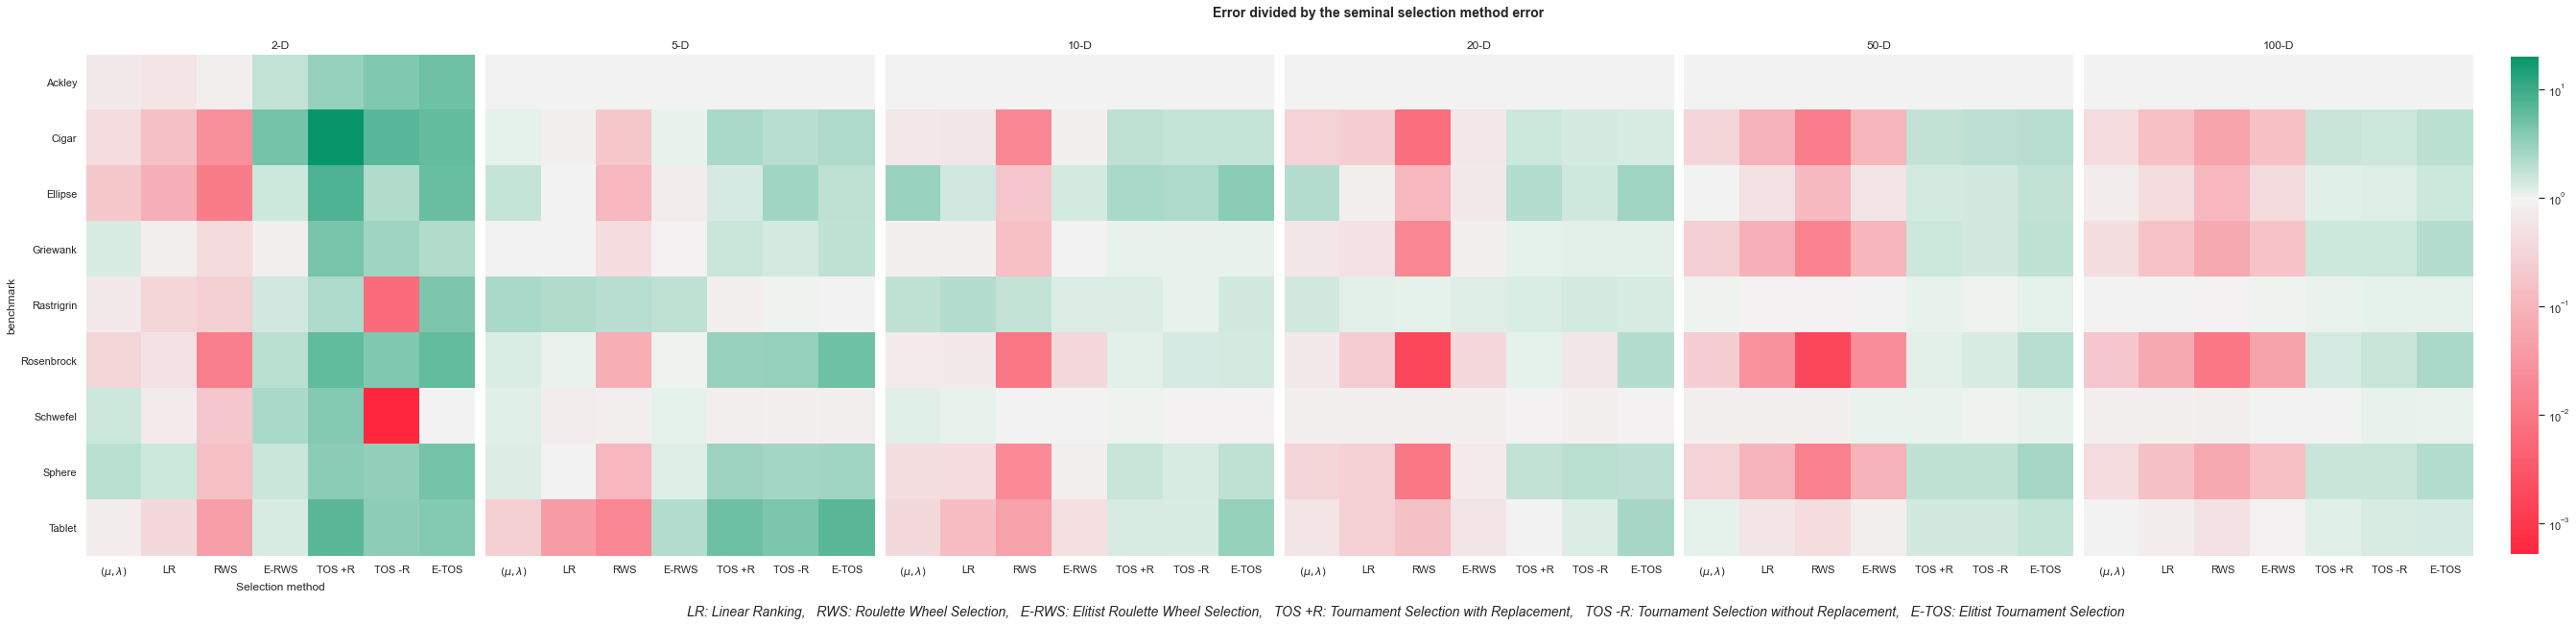

In [122]:
fig, axs = plt.subplots(nrows=1,ncols=len(dimensions), figsize=(40,9))

min_error = heatmap_nd_data.error.min()
max_error = heatmap_nd_data.error.max()

rdgn = sns.diverging_palette(h_neg=10, h_pos=150, s=99, l=55, sep=3, as_cmap=True)

counter =0 
for dim in dimensions:
    
    plot_data = heatmap_nd_data[heatmap_nd_data['dimensions'] == dim]
    
    plot_data = plot_data.pivot(index='selection_method', columns='benchmark', values='error') 

    plot_data = plot_data[plot_data.index == 'seminal'].squeeze() /plot_data
    plot_data = plot_data[~(plot_data.index == 'seminal')]
    plot_data = plot_data.transpose()[column_order]
    
    if counter == 0:
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=MidPointLogNorm(vmin=lowest, vmax=highest, midpoint=1), cmap=rdgn, cbar=False, square=True) #norm=LogNorm(vmin=min_error, vmax=max_error)
#         ax = sns.heatmap(plot_data, ax=axs[counter], cmap='YlGnBu', cbar=False, square=True, vmin=lowest, vmax=highest)
        ax.set_title(f'{dim}-D')
        ax.set_xlabel('Selection method')
        
    elif counter < len(dimensions)-1:
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=MidPointLogNorm(vmin=lowest, vmax=highest, midpoint=1), cmap=rdgn, cbar=False, square=True) #norm=LogNorm(vmin=min_error, vmax=max_error)
#         ax = sns.heatmap(plot_data, ax=axs[counter], cmap='YlGnBu', cbar=False, square=True, vmin=lowest, vmax=highest)
        ax.set(yticklabels=[])
        ax.set_title(f'{dim}-D')
        ax.set_ylabel('') 
        ax.set_xlabel('')
    elif counter >= len(dimensions)-1:
        cbar_ax = fig.add_axes([.91, .1, .01, 0.80]) #[Horizontal coordinate of the lower left corner,  Vertical coordinate of the lower left corner, Width of the subplot,  Height of the subplot]
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=MidPointLogNorm(vmin=lowest, vmax=highest, midpoint=1), cmap=rdgn, square=True, cbar_ax=cbar_ax)#norm=LogNorm(vmin=min_error, vmax=max_error)
#         ax = sns.heatmap(plot_data, ax=axs[counter], cmap='YlGnBu', square=True, cbar_kws={"shrink": 5}, cbar_ax=cbar_ax, vmin=lowest, vmax=highest)
        ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
        ax.set(yticklabels=[])
        ax.set_title(f'{dim}-D')
        ax.set_ylabel('')
        ax.set_xlabel('')
        
    counter+=1
    
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle('Error divided by the seminal selection method error', fontsize=14, fontweight='bold')
fig.text(0.25, 0,
         'LR: Linear Ranking,   RWS: Roulette Wheel Selection,   E-RWS: Elitist Roulette Wheel Selection,   TOS +R: Tournament Selection with Replacement,   TOS -R: Tournament Selection without Replacement,   E-TOS: Elitist Tournament Selection',
         fontsize=14, style='italic')
plt.savefig('PPA/notebooks/images/heatmap-vs-seminal.png')

plt.show()


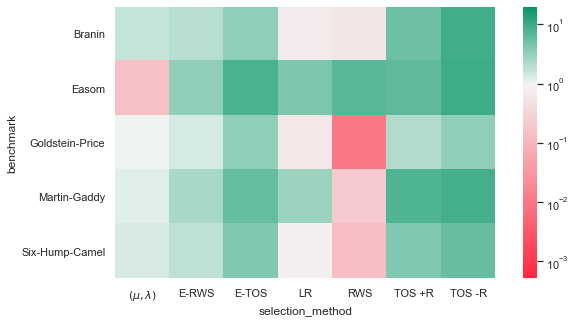

In [76]:
heatmap_2d_data = df_2d[['selection_method', 'benchmark','error']].groupby(['selection_method','benchmark']).median().reset_index()
heatmap_2d_data = heatmap_2d_data.replace({"selection_method": renames})
heatmap_2d_data = heatmap_2d_data.pivot(index='selection_method', columns='benchmark', values='error')
fig, axs = plt.subplots(ncols=1, figsize=(10,5))

heatmap_2d_data = heatmap_2d_data[heatmap_2d_data.index == 'seminal'].squeeze() /heatmap_2d_data
heatmap_2d_data = heatmap_2d_data[~(heatmap_2d_data.index == 'seminal')].transpose()

ax = sns.heatmap(heatmap_2d_data, ax=axs, norm=MidPointLogNorm(vmin=lowest, vmax=highest, midpoint=1), cmap=rdgn, square=True)
ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)

plt.show()

### Making line charts CAN'T USE THESE BECAUSE THE ERROR OVER DIMENSION IS NOT CONTINUES

In [ ]:
for benchmark in df_nd.benchmark.unique():
    data = df_nd[df_nd['benchmark'] == benchmark]
    grouped = data.groupby(['selection_method', 'dimensions']).median().reset_index()

    for method in grouped.selection_method.unique():
        plot_data = grouped[grouped.selection_method == method]
        sns.lineplot(x=plot_data.dimensions,y=plot_data.error,label=method, marker='o')
    plt.title(f'Error for {benchmark} per dimension')
#     plt.yscale("log")
    plt.savefig(f'PPA/notebooks/images/linecharts_per_benchmark/{benchmark}.png', bbox_inches='tight')
    plt.show()
    
#     plt.title('test')

### Barcharts comperative

In [79]:
grouped_nd = df_nd.groupby(['benchmark','selection_method', 'dimensions']).median().reset_index()
grouped_2d = df_2d.groupby(['benchmark','selection_method', 'dimensions']).median().reset_index()

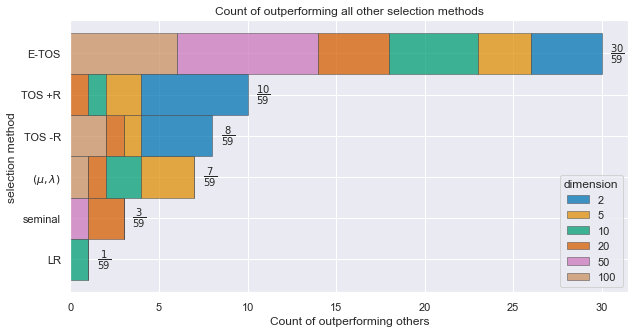

In [124]:
with sns.axes_style("dark"):
    plt.figure(figsize=(10, 5))   
    
    count_df = pd.DataFrame(columns=['selection_method','dimension','counter'])
    
    for benchmark in grouped_nd.benchmark.unique():
        for dimension in grouped_nd.dimensions.unique():
            benchmark_dim_data = grouped_nd[(grouped_nd.benchmark == benchmark) & (grouped_nd.dimensions == dimension)]
            min_id = benchmark_dim_data.error.argmin()
            count_df = count_df.append({"selection_method":benchmark_dim_data.iloc[min_id].selection_method,"dimension":int(dimension),"counter":1}, ignore_index=True)
    
    for benchmark in grouped_2d.benchmark.unique():
        benchmark_2d_data = grouped_2d[(grouped_2d.benchmark == benchmark)]
        min_id = benchmark_2d_data.error.argmin()
        count_df = count_df.append({"selection_method":benchmark_2d_data.iloc[min_id].selection_method,"dimension":int(2),"counter":1}, ignore_index=True)
        
    count_df = count_df.groupby(['selection_method','dimension']).sum().reset_index().sort_values(by=['counter','dimension'],ascending=False)
    g = sns.histplot(count_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)
    
    i = 0
    for index,row in count_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).iterrows():

        g.text(row.counter+0.9, abs(0-i), r'$\dfrac{%d}{59}$'%(row.counter), horizontalalignment='center', verticalalignment='center')
        i+=1
        
    plt.grid()
    plt.title('Count of outperforming all other selection methods')
    plt.ylabel('selection method')
    plt.xlabel('Count of outperforming others')
    plt.savefig(f'PPA/notebooks/images/barcharts_per_benchmark/score_per_selection_and_dimension.png', bbox_inches='tight')
    plt.show()

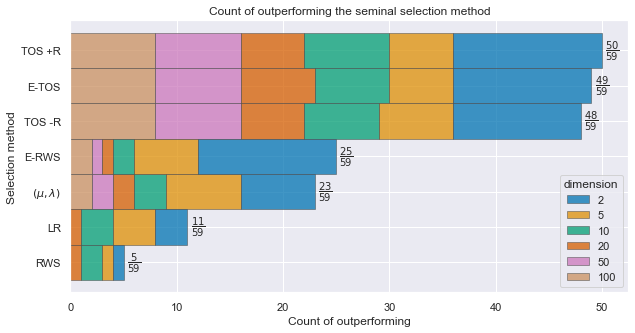

In [129]:
with sns.axes_style("dark"):
    
    plt.figure(figsize=(10, 5))
    data = grouped_nd[~(grouped_nd['selection_method'] == 'seminal')]
    outperforms_df = pd.DataFrame(columns=['selection_method','dimension','counter'])
    
    for benchmark in data.benchmark.unique():
        for dim in data.dimensions.unique():
        
            original_error = grouped_nd[(grouped_nd['selection_method']=='seminal') & (grouped_nd['benchmark']==benchmark) & (grouped_nd['dimensions']==dim)]['error']
            for method in data.selection_method.unique():
                
                selection_method_error = data[(data['selection_method']==method) & (data['benchmark']==benchmark) & (data['dimensions']==dim)]['error']
                if float(original_error) > float(selection_method_error):
                    outperforms_df= outperforms_df.append({"selection_method":method,"dimension":int(dim),"counter":1}, ignore_index=True)
    
    data = grouped_2d[~(grouped_2d['selection_method'] == 'seminal')]
    for benchmark in data.benchmark.unique():
        
        original_error = grouped_2d[(grouped_2d['selection_method']=='seminal') & (grouped_2d['benchmark']==benchmark)]['error']
 
        for method in data.selection_method.unique():
            
            selection_method_error = data[(data['selection_method']==method) & (data['benchmark']==benchmark)]['error']
            if float(original_error) > float(selection_method_error):
                outperforms_df= outperforms_df.append({"selection_method":method,"dimension":int(2),"counter":1}, ignore_index=True)

outperforms_df = outperforms_df.groupby(['selection_method','dimension']).sum().sort_values(by=['counter'],ascending=False)

#used for sorting the data
outperforms_df = outperforms_df.loc[(outperforms_df.groupby('selection_method').sum().sort_values('counter', ascending=False).index.values)].reset_index()


g = sns.histplot(outperforms_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)
# print(outperforms_df)
i = 0
for index,row in outperforms_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).iterrows():
    g.text(row.counter+1, abs(0-i), r'$\dfrac{%d}{59}$'%(row.counter), horizontalalignment='center', verticalalignment='center')
    i+=1
    
plt.grid()
plt.title('Count of outperforming the seminal selection method')
plt.ylabel('Selection method')
plt.xlabel('Count of outperforming')
plt.grid()
plt.savefig(f'PPA/notebooks/images/barcharts_per_benchmark/outperforming_seminal_per_selection_and_dimension.png', bbox_inches='tight')
plt.show()

In [294]:
# import collections
# import json

# def construct_trees_by_TingYu(edges):
#     """Given a list of edges [child, parent], return trees. """
#     trees = collections.defaultdict(dict)

#     for child, parent in edges:
#         trees[parent][child] = trees[child]

#     # Find roots
#     children, parents = zip(*edges)
#     roots = set(parents).difference(children)

#     return {root: trees[root] for root in roots}

# if __name__ == '__main__':
# #     edges = [[0, 6], [17, 5], [2, 7], [4, 14], [12, 9], [15, 5], [11, 1], [14, 8], [16, 6], [5, 1], [10, 7], [6, 10], [8, 2], [13, 1], [1, 12], [7, 1], [3, 2], [19, 12], [18, 19]]
#     edges = [[8,5],[7,5],[4,2],[5,2],[6,3],[2,1],[3,1]]
# #     edges = test.heritage.relations
#     results = json.dumps(construct_trees_by_TingYu(edges), indent=1)
#     print(results)
# #     with open('PPA/notebooks/test4.json', 'w') as outfile:
# #         json.dump(results, outfile)

### Graphical drawing

In [128]:
# try:
#     test = pickle.load(open(r"PPA/results/test/mc-test.p", "rb"))
selection_method= 'tournament'
benchmark_name = 'Tablet'
dimensions = 2
benchmark_df = df_nd[(df_nd['benchmark'] == benchmark_name) & (df_nd['selection_method'] == selection_method) & (df_nd['dimensions'] == dimensions)]
run_n = benchmark_df[benchmark_df['error']==benchmark_df['error'].quantile(interpolation='nearest')]['run_n']
test = pickle.load(open(f"PPA/results/results-2021-05-19_13-52-40/{selection_method}-{benchmark_name}{dimensions}Drun-{int(run_n)}.p", "rb"))

# selection_method2 = 'mupluslambda'
# benchmark_name2 = 'Tablet'
# dimensions2 = 2
# benchmark_df2 = df_nd[(df_nd['benchmark'] == benchmark_name2) & (df_nd['selection_method'] == selection_method2) & (df_nd['dimensions'] == dimensions2)]
# run_n2 = benchmark_df2[benchmark_df2['error']==benchmark_df2['error'].quantile(interpolation='nearest')]['run_n']
# test2 = pickle.load(open(f"PPA/results/results-2021-05-19_13-52-40/{selection_method2}-{benchmark_name2}{dimensions2}Drun-{int(run_n2)}.p", "rb"))

# except Exception as e:
#     print(e) # 


TypeError: cannot convert the series to <class 'int'>

In [8]:
#load the data in an edge dataframe
edge_df = pd.DataFrame(test.heritage.relations, columns=['source','target'])
temp = edge_df.copy()
edge_df['source'] = edge_df['target']
edge_df['target'] = temp['source']
edge_df.loc[edge_df['source'] == -1, 'source'] = 0
edge_df['edge_color'] = "grey"

In [127]:
edge_df.to_csv('PPA/notebooks/edge_test.csv')

NameError: name 'edge_df' is not defined

In [9]:
parent_ids = []
for individual in test.parent_population:
    for parent in individual.parents:
        parent_ids.append(parent['id'])
edge_df.loc[edge_df["target"].isin(parent_ids),'edge_color'] = "red"


In [10]:
fitnesses = []
for individual in test.parent_population:
    for parent in individual.parents:
        parent['id']
        break

In [14]:
g = igraph.Graph.TupleList(edge_df.itertuples(index=False), directed=True, weights=False)
# g.vs["label"] = g.vs["name"]
# g.es["color"] = "lightgrey" #color of edges
g.es["color"] = edge_df['edge_color']
g.es["font"] = 1
g.vs["color"] = "blue" #color of the vertixes (the dots)

#load the id's of the final population
final_individuals_id = [i.id for i in test.parent_population]
final_individuals_objectives = [round(i.objective_value,4) for i in test.parent_population]

final_individuals_verticex = g.vs.select(name_in=final_individuals_id)
final_individuals_verticex['color'] = 'green'
final_individuals_verticex['vertex_size'] = 50
final_individuals_verticex['label'] = final_individuals_objectives

# plot(g, layout = layout)
# good layouts: layout_lgl() layout_reingold_tilford_circular

layout = g.layout_reingold_tilford(root=0)
_ = igraph.plot(g, layout=layout, 
     edge_arrow_size=0.2, 
     vertex_label_cex=0,  
#      vertex_label_family="Arial",  
#      vertex_label_font=50, 
     vertex_shape="circle", 
     vertex_size=5, 
     vertex_label_color="red",  
     edge_width=0.5,
     rescale=False,
     bbox=(5000,5000), target='PPA/notebooks/test6.png')
print('done')
#  edge.arrow.size=0.5, vertex.label.cex=0.75, vertex.label.family="Helvetica", vertex.label.font=2, vertex.shape="circle", vertex.size=1, vertex.label.color="black",  edge.width=0.5

done


## Some heritage plots

### individuals per generation

Text(0, 0.5, '# of individuals')

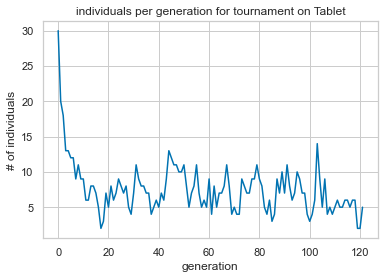

In [110]:
indivuals_per_generation = pd.DataFrame(test.heritage.unique_individual_count, columns=['generation', '#individuals'])
plt.plot(indivuals_per_generation['generation'], indivuals_per_generation['#individuals'])
plt.title(f'individuals per generation for {test.survivor_selection_name} on {test.benchmark_name}')
plt.xlabel('generation')
plt.ylabel('# of individuals')

### Average age per generation

Text(0, 0.5, 'mean age')

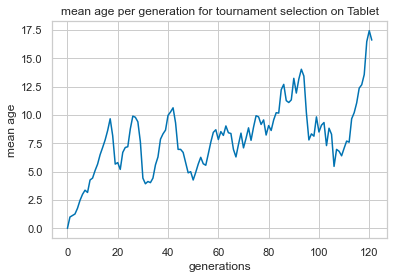

In [89]:
mean_ages_per_generation = []
data = test.heritage.ages_per_generation
i = 0
for value in data:
    mean_ages_per_generation.append([value,np.mean(data[value])])
    i+=1
mean_ages_per_generation = pd.DataFrame(mean_ages_per_generation, columns=['generation','mean_age'])
plt.plot(mean_ages_per_generation['generation'],mean_ages_per_generation['mean_age'])
plt.title(f'mean age per generation for {test.survivor_selection_name} selection on {test.benchmark_name}')
plt.xlabel('generations')
plt.ylabel('mean age')

Text(0, 0.5, 'mean age')

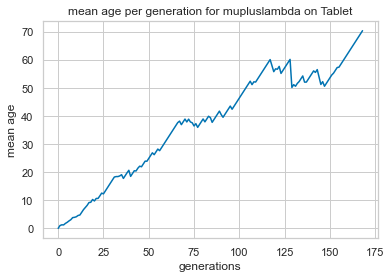

In [132]:
mean_ages_per_generation = []
data = test.heritage.ages_per_generation
i = 0
for value in data:
    mean_ages_per_generation.append([value,np.mean(data[value])])
    i+=1
mean_ages_per_generation = pd.DataFrame(mean_ages_per_generation, columns=['generation','mean_age'])
plt.plot(mean_ages_per_generation['generation'],mean_ages_per_generation['mean_age'])
plt.title(f'mean age per generation for {test.survivor_selection_name} on {test.benchmark_name}')
plt.xlabel('generations')
plt.ylabel('mean age')